# Neural style

V tomto cvičení si vyzkoušíme tzv. přenos stylu mezi obrázky tak, jak byl původně navržen v článku [Gatys et al.: A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576). Na zdrojový obrázek s obsahem (content) aplikujeme vizuální styl z jiného obrázku, čímž vznikne kombinace obou. Viz příklad:

<table>
  <tr>
    <td><img src="https://github.com/leongatys/fast-neural-style/raw/leon/images/content/chicago.jpg" style="height: 200px;"/></td>
     <td/>+
    <td><img src="https://github.com/leongatys/fast-neural-style/raw/leon/images/styles/the_scream.jpg" style="height: 200px;"/></td>
      <td/>=
    <td><img src="https://github.com/leongatys/fast-neural-style/raw/leon/images/outputs/chicago_scream.jpg" style="height: 200px;"/></td>
    </tr>
</table>

Princip je vysvětlen v přednášce, zde proto již jen stručně:
- máme celkem tři obrázky: obsahový (content) obrázek $p$, obrázek stylu $a$ a kombinovaný výstupní obrázek $x$
- problém je formulován jako nalezení optimálního $x$, který sdílí obsah s $p$, ale vizuální styl přebírá z $a$
- podobnost obsahů se namísto pixelů měří na úrovni příznaků z konvolučních map $F^l$ a $P^l$ extrahovaných z obrázků $x$ a $p$, přičemž $l$ značí zvolenou vrstvu
- hledáme tedy takový obr. $x$, který minimalizuje $$L_c = \sum_{i,j}(F_{ij}^l - P_{ij}^l)^2$$
- podobnost stylů se měří pomocí gram korelačních matic $G_{ij}^l$ vypočtených z příznakové repezentace jako $$G_{ij}^l = \sum_k{F_{ik}^lF_{jk}^l}$$
- optimální $x$ tedy musí zároveň minimalizovat také $$E^l = \sum_{i,j}(G_{ij}^l - A_{ij}^l)^2$$ kde $A^l$ je gram matice extrahovaná  z $l$-té konvoluční mapy obrázku $a$
- u $L_s$ typicky uvažujeme více než jednu vrstvu $l$, přičemž každá pak má přizazenu váhu $w^l$ a pak $$L_s = \sum_{l \in W} w^l\cdot E^l$$
- celkové kritérium tedy je $L = \alpha L_c + \beta L_s$, kde $\alpha,\beta$ jsou hyperparametry balancující důležitost obshau a stylu

In [ ]:
%matplotlib inline

In [ ]:
import cv2
import numpy as np
from matplotlib import animation
import matplotlib.pyplot as plt
from PIL import Image
from skimage import io
import tqdm

from IPython.core.debugger import set_trace
from IPython.display import HTML

plt.rcParams['figure.figsize'] = (12., 8.)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Kvůli `tqdm`, které na některých počítačích neustále otravuje s jedním varováním:

In [ ]:
import warnings
if hasattr(tqdm, 'TqdmSynchronisationWarning'):
    # plati jen pro novejsi verze
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", tqdm.TqdmSynchronisationWarning)

In [ ]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch import nn
from torch import optim
from torchvision import models
from torchvision import transforms

USE_CUDA = torch.cuda.is_available()
USE_CUDA

Jak si můžete v notebooku vyzkoušet, neural style je velmi citlivý na změny rozlišení. Je tomu tak proto, že stejná konvoluční mapa $l$-té vrstvy má pro různá rozlišení různý relativní receptive field, tj. vidí jinak velkou část vstupního obrázku. Na stejné vrstvě tedy pouhou změnou rozlišení dostaneme úplně jiné příznaky a pro dosažení stejného či alespoň podobného výsledku je nutné poupravit hyperparametry algoritmu. Pro jednoduchost proto oba obrázky $p$ a $s$ normalizujeme na stejnou čtvercovou velikost.

### Upozornění

Tento notebook je nastavený na trénování s použitím GPU při rozlišení 512x512 pixelů. **Bez GPU však s tímto rozlišením bude optimalizace velmi pomalá.** Snížením rozlišení ale zároveň dojde k "rozladění" vah a kdo bude počítat pouze na CPU, bude si pravděpodobně muste pohrát s hyperparametry, především s váhami jednotlivých vrstev u style lossu.

In [ ]:
img_size = 512 if USE_CUDA else 128

# std. predzpracovani vsech PyTorch predtrenovanych modelu
normalize = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

# chceme ctvercovy obrazek o zadanem rozliseni
prep = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    normalize,
])

In [ ]:
def load_image(srcfile, prep=None):
    """
    nacte obrazek ze souboru nebo z url a vrati jako torch Variable
    """
    img = io.imread(srcfile)
    img = Image.fromarray(img[..., :3])
    
    if prep is not None:
        img = prep(img)
    
    if not isinstance(img, torch.Tensor):
        img = transforms.ToTensor()(img)
    
    img = img.unsqueeze(0)
    img = Variable(img, requires_grad=False)
    if USE_CUDA:
        img = img.cuda()
    
    return img

In [ ]:
def unprep(var):
    """
    z torch Variable vyrobi numpy ndarray zobrazitelny matplotlib imshow
    """
    rgb = var.data.cpu().numpy()[0].transpose(1, 2, 0)
    rgb *= np.array([0.229, 0.224, 0.225])
    rgb += np.array([0.485, 0.456, 0.406])
    return rgb.clip(0., 1.)

Následující funkce se může hodit pro inicializaci přenosu stylu, kdy místo původním obrázkem můžeme metodu inicializovat jeho šedotónovou variantou.

In [ ]:
def rgb2gray(tensor):
    """
    prevede RGB obrazek do sedotonu pri zachovani rozmeru 1x3xHxW
    """
    gray = 0.299 * tensor[..., 0, :, :] + 0.587 * tensor[..., 1, :, :] + 0.114 * tensor[..., 2, :, :]
    return torch.stack((gray, gray, gray), dim=1)

Načteme content obrázek.

In [ ]:
c_img = load_image('https://bawza.com/wp-content/uploads/2018/03/stephen-hawking-smiling-1979-restricted-exlarge-169.jpg', prep=prep)

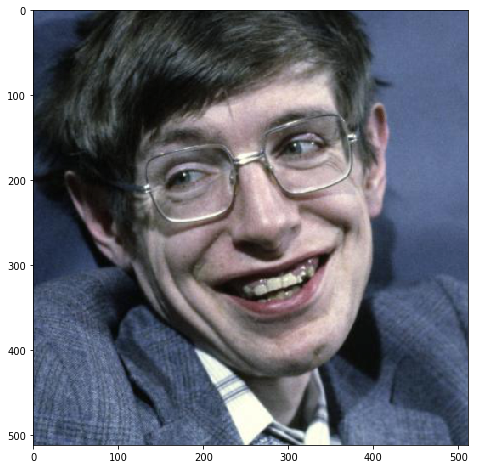

In [ ]:
plt.imshow(unprep(c_img))
plt.show()

Načteme style obrázek.

In [ ]:
s_img = load_image('https://cdn.shopify.com/s/files/1/1332/8123/products/sidney-perry-105613_1024x1024.jpg?v=1489214536', prep=prep)

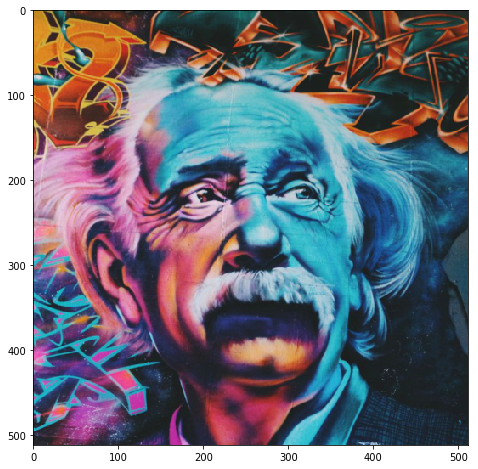

In [ ]:
plt.imshow(unprep(s_img))
plt.show()

Stačit nám bude nějaká z předtrénovaných sítí. V původním článku byla použita VGG-19, zvolíme ji tedy i zde.

In [ ]:
# u VGG nam staci pouze `features` cast, klasifikacni cast site nepotrebujeme
cnn = models.vgg19(pretrained=True).features
cnn

Jak se píše v původním článku, o něco lepší výsledky lze dosáhnout výměnou všech max-pooling vrstev za average pooling. Učiňte tak v následující buňce.

In [ ]:
...

Pokud síť netrénujeme, nikdy nezapomínejme na `eval`. U VGG bez batch noramlizace a dropoutu to sice není potřeba, i tak se ale jedná o dobrou praxi.

In [ ]:
cnn.eval()

if USE_CUDA:
    cnn.cuda()

A jelikož netrénujeme, pro efektivnější výpočet zablokujeme i výpočet gradientů při zpětném průchodu.

In [ ]:
for name, par in cnn.named_parameters():
    par.requires_grad = False

## Rekonstrukce obsahu

Jako první vyzkoušíme rekonstrukci pouze za použítí obsahu, tj. bez stylu. Výstupní obrázek `c_rec` inicalizujeme na náhodný šum a budeme optimalizovat tak, aby měl stejnou příznakovou reprezentaci jako content obrázek `c_img`.

Byť u rekonstrukce pouze z obsahu se to spíše netýká, pro výpočet style lossu budeme potřebovat příznaky z více než jedné vnitřních vrstev sítě. Při zavolání `cnn.forward(x)`  nám však PyTorch vrátí pouze výstup z poslední vrstvy sítě, přičemž k mezivýpočtům nemáme přístup. Existuje několik přístupů, jak toto omezení obejít:

1. Mohli bychom vytvořit vlastní kopii třídy `VGG`, u níž bychom přepsali metodu `forward` tak, aby vracela nebo někam ukládala vypočtené příznaky z vnitřních vrstev. Zřejmou nevýhodou tohoto postupu je časová náročnost a to především při pčípadné výměně modelu za jinou architekturu, kdy bychom museli dopředný průchod psát vždy celý znovu.

2. Můžeme využít faktu, ze `features` část architektury `VGG` je v PyTorch typu `nn.Sequential` a tedy dopředný průchod je pouze sekvenční aplikace vnitřních modelů tak, jak za sebou byly definovány při vytvoření. Mohli bychom tedy ve `for` cyklu postupně počítat příznaky a kontrolovat, zda číslo vrstvy je v nějakém poli, které označuje, jaké vrstvy nás zajímají. Nevýhodou je, že tento postup bude fungovat jen pro takto jednoduché sítě.

3. **Použijeme PyTorch koncept hooků, což jsou callback funkce, které se volají při dopředném a zpětném průchodu u každé vrstvy.**

Pytorch umožňuje registrovat hook funkci pro dopředný průchod nějakého modulu metodou `module.register_forward_hook`. Funkce jako parametr převezme jinou callback funkci, která se zavolá **po dokončení** dopředného průchodu tímto modulem a dostane jako argumenty aktuální modul, jeho vstup a vypočtený výstup. Právě výstup si pak v této callback funkci jednoduše uložíme do nějakého pole.

Následující funkce pro extrakci příznaků tento postup implementuje. *Při každém* dopředném průchodu sítí zaregistruje dopředné hooky, zavolá dopředný průchod, a hooky znovu odregistruje. Registrace je poměrně efektivní a ke zvoleným submodulům sítě pouze přidá do pole hooků naše callbacky. Naprostá většina času této funkce tedy stále bude tvořena samotným výpočtem konvolučních příznaků, tj. dopředným průchodem sítí.

In [ ]:
def extract_features(x, net, c_layers, s_layers):
    """
    Pomoci sitew `net` extrahuje konvolucni priznaky obrazku `x` na zvolenych vrstvach `c_layers` a `s_layers`.
    
    Vrati dvojici `c_outputs`, `s_outputs`, coz jsou pole, ktere obsahuji extrahovane konv. mapy odpovidajici vrstvam
    `c_layers`, `s_layers`.
    """
    c_outputs = []
    s_outputs = []
    handles = []
    
    for name, module in net.named_modules():
        if name in c_layers:
            h = module.register_forward_hook(lambda m, i, o: c_outputs.append(o))
            handles.append(h)
        if name in s_layers:
            h = module.register_forward_hook(lambda m, i, o: s_outputs.append(o))
            handles.append(h)
    
    x = net(x)
    
    for h in handles:
        h.remove()
    
    return c_outputs, s_outputs

Ve výpisu výše je vidět struktura sítě včetně názvů. Pro reprezentaci zvolíme např. vrstvu `'conv4_2'`, která byla použita v článku Gatyse a kol. `nn.Sequential` má defaultně vrstvy pojmenované pouze číslem, správnou tedy najděte např. odpočítáním :-) Styl nás prozatím nezajímá, argument `s_layers` funkce `extract_features` tedy necháme prázdný.

In [ ]:
c_layers = [...]
c_targets, _ = extract_features(c_img, cnn, c_layers, [])

Nepotřebujeme v paměti držet celou historii výpočtu proměnné `c_targets`. Následujícím kódem ji "zahodíme".

In [ ]:
c_targets = [Variable(f.data, requires_grad=False) for f in c_targets]

Zadefinujeme funkci pro inicializaci výstupního obrázku náhodnými daty.

In [ ]:
def init_random(c, h, w):
    """
    vrati obrazek o rozmerech c x h x w inicializovany nahodnymi hodnotami
    vystup je standardne predzpracovany a navracen jako typ `Variable`
    """
    c_rec = 0.5 + 0.1 * torch.randn(c, h, w).float()
    c_rec.clamp_(0., 1.)
    c_rec = normalize(c_rec).unsqueeze(0)
    if USE_CUDA:
        c_rec = c_rec.cuda()
    return Variable(c_rec, requires_grad=True)

In [ ]:
c_rec = init_random(*c_img.shape[1:])
c_rec.shape

In [ ]:
plt.imshow(unprep(c_rec))
plt.show()

### Optimalizace

Pro optimalizaci stejně jako v původním článku použijeme metodu [L-BFGS](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm). L-BFGS patří do skupiny [kvazi-newtonovských](https://en.wikipedia.org/wiki/Quasi-Newton_method), které v každém kroku lokálně aproximují povrch kvadratickou funkcí (např. parabola v 1D), u níž se snaží najít minimum. Viz obrázek:

![Newtonova metoda](https://ardianumam.files.wordpress.com/2017/09/newtonmethodforoptim1.jpg)
Zdroj: [https://ardianumam.wordpress.com/2017/09/27/newtons-method-optimization-derivation-and-how-it-works/](https://ardianumam.wordpress.com/2017/09/27/newtons-method-optimization-derivation-and-how-it-works/)

V následujícím kroku se pak přesuneme do tohoto minima a proces se opakuje. K aproximaci paraboloidem je však potřeba matice druhých derivací ([Hessián](https://en.wikipedia.org/wiki/Hessian_matrix)), jejíž výpočet je náročný, což *kvazi-* metody obcházejí aproximací pomocí prvních derivací ([Jakobián](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant)). Výhodou těchto metod je  automatický výpočet velikosti kroku a není tedy u nich potřeba nastavovat learning rate. Pro běžné učení sítí s mini-dávkami (minibatch) se však nehodí, protože jsou citlivé na změny lokální charakteristiky povrchu optimalizované funkce, k čemuž u minibatch učení dochází, jelikož pokaždé navzorkujeme jiná data. U style transferu žádné minibatche nemáme, díky čemuž se vlastnosti optimalizované funkce nemění a použitím L-BFGS dosáhneme rychlejší konvergence.

In [ ]:
c_opt = optim.LBFGS([c_rec])

In [ ]:
c_loss_history = []
c_rec_history = []
c_rec_features = None

V PyTorch je při použití 2nd-order metody L-BFGS nutné poupravit trénovací kód. Pro automatický výpočet velikosti kroku je nutné optimalizovanou funkci vyhodnotit vícekrát, než dojde k samotnému updatu pozice. Funkce `optimizer.step` proto vyžaduje parametr `closure`, což je naše optimalizovaná funkce, která extrahuje příznaky, porovná je s referencí, vrátí hodnotu lossu a vypočte gradienty v aktuálním bodě, a optimizer si ji může zavolat jako callback, kolikrát bude potřebovat. Jde vlastně o vnitřek "trénovacího" cyklu a vaším úkolem je doplnit jeho kód.

In [ ]:
def c_closure():
    # jako global muzeme definovat promenne, na ktere se budeme chtit podivat po skonceni fce, napr. pro debugovaci ucely
    global c_rec_features
    
    # dopredny pruchod
    ...
    
    c_loss = ...
    losses_.append(float(c_loss))
    
    # zpetny pruchod
    ...
    
    return c_loss

Struktura kódu pro trénování je tak o něco jednodušší. Na GTX 1070 8GB trvá jedna iterace cca 1.5 s, tzn. cyklus o 100 iteracích přibližně dvě a půl minuty. Pro kontrolu, zda optimalizace "něco dělá", stačí i mnohem méně, např. 20 iterací. Nemusíte tedy vždy čekat plnou dobu.

In [ ]:
pb = tqdm.tnrange(100)
for i in pb:
    losses_ = []
    c_opt.step(c_closure)
    c_loss_history.append(np.mean(losses_))
    pb.set_postfix(loss='{:.3f}'.format(c_loss_history[-1]), n_closures=str(len(losses_)))
    
    if (i + 1) % 5 == 0:
        c_rec_history.append(unprep(c_rec))

Podle zvolené vrstvy bude vypadat i rekonstrukce. Čím vyšší vrstva, tím více detailů z původního obrázku se ztratí a reprezetnace bude odpovídat spíše "vysokoúrovňovým" příznakům. Při použítí v článku doporučené vrstvy tedy nebude rekonstrukce dokonalá a může obsahovat poměrně značné množství šumu. Při použití nižší vrstvy bude rekonstrukce mnohem čistší.

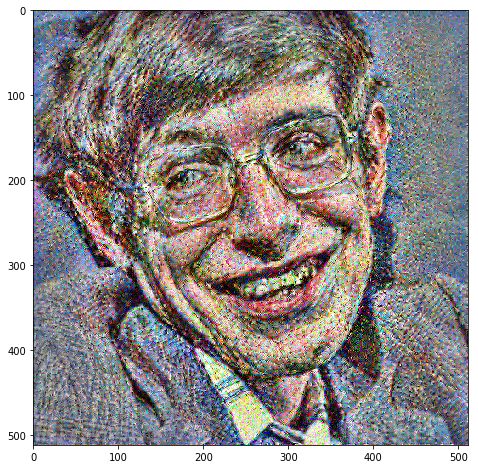

In [ ]:
plt.imshow(unprep(c_rec))
plt.show()

Pro debugovací účely může být výhodné podívat se na vývoj optimalizace. Zde je funkce pro vykreslení sekvence obrázků jako animace.

In [ ]:
def animate_history(img_history, figsize=None, interval=500):
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(img_history[0], animated=True)
    
    def anim(frame):
        im.set_data(img_history[frame])
        return im,
    
    ani = animation.FuncAnimation(fig, anim, frames=len(img_history), interval=interval, blit=True)
    plt.close(fig)
    return HTML(ani.to_html5_video())

In [ ]:
animate_history(c_rec_history)

Zobrazíme si i průběh lossu.

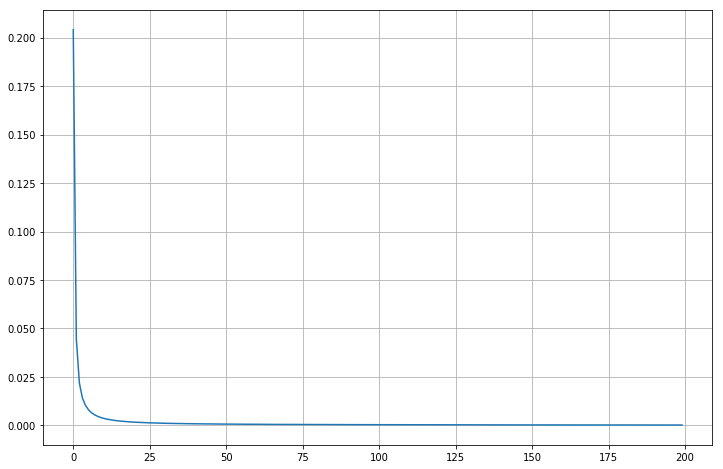

In [ ]:
plt.plot(c_loss_history)
plt.grid()
plt.show()

## Rekonstrukce stylu

Nyní zkusíme to samé i se stylem. Pokusíme se rekonstruovat obrázek `s_img`, tentokrát ovšem pouze na základě korelačních gram matic. vizualizujeme si tak stylovou informaci, která se později z `s_img` bude přenášet na obsahový obrázek `c_img`.

Podobnost stylů se měří gram maticemi. Zadefinujeme si proto funkci, která z konvoluční mapy $F^l$ $l$-té vrstvy tyto korelační matice vyrobí. Ještě jednou vzoreček: $$G_{ij}^l = \sum_k{F_{ik}^lF_{jk}^l}$$

**Pozn.:** matice $G^l$ není ve vzorcích normalizovaná svou velikostí. Namísto toho je v původním článku normalizační koeficient vytknut před závorku při výpočtu lossu, viz proměnná $M^l$ ve vztahu (4) článku Gatyse a kol. Jelikož ve fci `gramstat` je jednoduché z `fetmap` zjistit velikost, můžete normalizaci vydělením `h` x `w` zahrnout již sem.

In [ ]:
def gramstat(featmap):
    """
    vstup:
      featmap ... konvolucni mapa (priznaky) o rozmerech b x c x h x w, kde b=1 je batch dimenze
    vystup:
      gram ... korelacni matice o rozmerech b x c x c
    """
    ...
    return gram

Zvolíme konvoluční vrstvy, ze kterých styl budeme extrahovat. Na rozdíl od obsahu jich tentokrát bude více. V článku byly použity tyto vrstvy: `'conv1_1'`, `'conv2_1'`, `'conv3_1'`, `'conv4_1'` a `'conv5_1'`. Obsah nás momentálně nezajímá, a tak jako parametr `c_layers` do funkce `extract_features` zadáme prázdné pole. Reference pro styl `s_targets` budou tentokrát gram matice.

In [ ]:
s_layers = ...
s_targets = ...

Opět zahodíme výpočetní historii (graf).

In [ ]:
s_targets = ...

### Váhy

Nyní jedno z klíčových "šamanství" style transferu, kterým jsou zvolené váhy. Jejich hodnoty mají poměrně výrazný vliv na výslednou podobu obrázku (vyzkoušejte si!). V původním článku doporučují nastavit váhy nepřímo úměrně druhé mocnině počtu filtrů ve vrstvě, tak se toho raději budeme držet. Váhy tedy nastavte dle
$$
w^l = \frac{\omega}{4W_l^2H_l^2C_l^2}
$$
kde $W_l$, $H_l$ a $C_l$ jsou šířka, výška a počet filtrů konv. mapy vrstvy $l$. $\omega$ je jakási "bulharská konstanta", která bohužel rozhoduje, zda celý algoritmus bude či nebude fungovat. Kvůli zaokrouhlování je důležité, aby style loss měl dostatečnou "energii". V opačném případě vyjdou velmi malé hodnoty gradientů, PyTorch je bude v rámci optimalizace považovat za nulu a během optimalizace se nestane vůbec nic. Tento stav poznáte tak, že proces optimalizace bude velmi rychlý, jedno až dvouřádově na iteraci oproti optimalizaci obsahu.

Parametr $\omega$ proto např. nastavte tak, aby nejmenší váha (pro nejvyšší vrstvu) byla rovna jedné. Nezapomeňte, že velikost vah navíc ještě ovlivňuje normalizace rozměry. Pokud se gram matice normalizuje už ve funkci `gramstat`, člen $W_l^2W_l^2$ do výpočtu $w_l$ již nepatří.

In [ ]:
s_weights = ...
# s_weights = [1.] * len(s_layers)  # muzete zkusit pro zacatek, melo by take fungovat, jen hure

Pro dosažení čístějšího kódu si také zadefinujeme funkci pro výpočet průměrné čtvercové odchylky z více vrstev s váhami $w^l$ zadanými v poli `weights`.

In [ ]:
def weighted_mean_squared_error(outputs, targets, weights=None, **kwargs):
    """
    Spocita prumernou ctvercovou odchylku mezi `outputs` a `targets`.
    
    `outputs` a `targets` jsou pole o shodne delce, kde kazdy prvek je jedna konv. mapa
    nepovinny parametr `weights` musi mit rovnez shodnou delku a kazde vrstve prirazuje vahu
    
    Vystupem je prumerna ctvercova odchylka (mean square error), tj. cislo
    """
    assert len(outputs) == len(targets)
    if not weights:
        weights = [1.] * len(targets)
    return ...

Inicializujeme `s_img` na náhodné hodnoty.

In [ ]:
s_rec = ...

In [ ]:
plt.imshow(unprep(s_rec))
plt.show()

In [ ]:
s_opt = optim.LBFGS([s_rec])

In [ ]:
s_loss_history = []
s_rec_history = []
s_rec_grams = None

In [ ]:
def s_closure():
    global s_rec_grams
    
    # dopredny pruchod
    ...
    losses_.append(float(s_loss))

    # zpetny pruchod
    ...
    
    return s_loss

In [ ]:
pb = tqdm.tnrange(100)
for i in pb:
    losses_ = []
    s_opt.step(s_closure)
    s_loss_history.append(np.mean(losses_))
    
    if (i + 1) % 5 == 0:
        s_rec_history.append(unprep(s_rec))
        pb.set_postfix(loss='{:.3f}'.format(s_loss_history[-1]), n_closures=len(losses_))

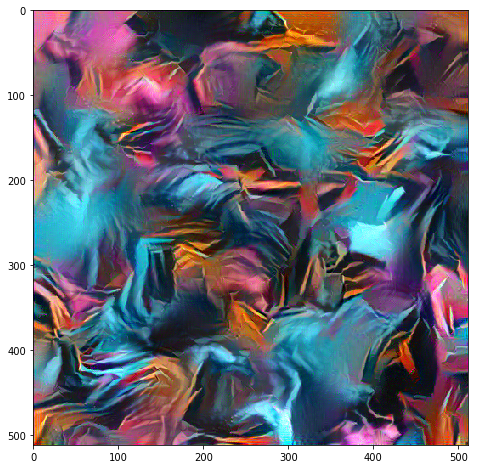

In [ ]:
plt.imshow(unprep(s_rec))
plt.show()

In [ ]:
animate_history(s_rec_history)

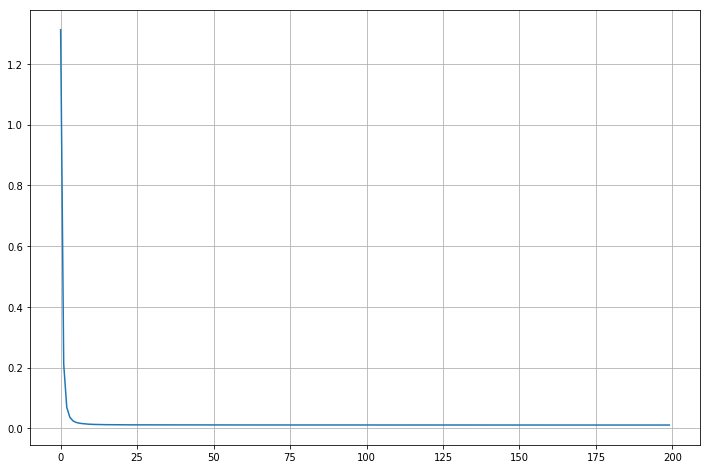

In [ ]:
plt.plot(s_loss_history)
plt.grid()
plt.show()

## Kombinace obsahu a stylu: style transfer

Po rekonstrukci pouze z obsahu nebo stylu nyní obě kritéria spojíme a provedeme transfer stylu. Opět vytvoříme nový obrázek, tentokrát však nainicializujeme jako kopii obsahu namísto náhodných hodnot.

In [ ]:
t_img = ...
t_img.shape, t_img.data.type()

In [ ]:
plt.imshow(unprep(t_img))
plt.show()

In [ ]:
t_opt = optim.LBFGS([t_img])

In [ ]:
t_loss_history = []
t_img_history = []

Celkové kritérium $L = \alpha L_c + \beta L_s$, kde $\alpha$ a $\beta$ jsou hyperparametry přiřazující obsahu a stylu různé váhy. Obrázek dole byl dosažen nastavením $\alpha=1$ a $\beta=4$. V původním článku se přitom uvádí poměry $\alpha/\beta = 10^{-4}\ldots 10^{-1}$. Rozdíl je daný tím, že v tomto notebooku byly váhy přeškálovány již výše, viz parametr $\omega$.

In [ ]:
def t_closure():
    # dopredny pruchod
    ...
    c_loss = ...
    s_loss = ...
    t_loss = ...  # celkovy loss

    losses_.append((float(c_loss), float(s_loss)))

    # zpetny pruchod
    ...
    
    return t_loss

In [ ]:
pb = tqdm.tnrange(200)
for i in pb:
    losses_ = []    
    t_opt.step(t_closure)
    t_loss_history.append(np.mean(losses_, axis=0))
    
    if (i + 1) % 5 == 0:
        t_img_history.append(unprep(t_img))
        pb.set_postfix(c_loss='{:.3f}'.format(t_loss_history[-1][0]),
                       s_loss='{:.3f}'.format(t_loss_history[-1][1]), n_closures=len(losses_))

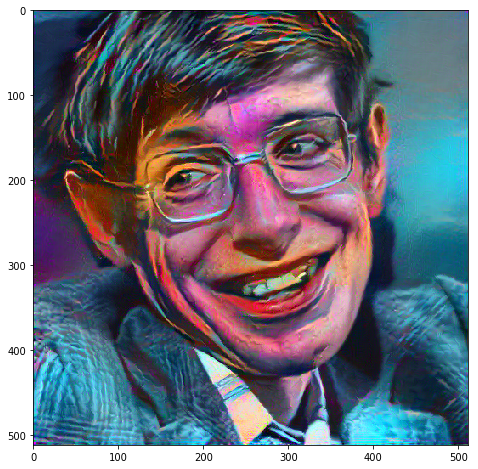

In [ ]:
plt.imshow(unprep(t_img))
plt.show()

In [ ]:
animate_history(t_img_history)

In [ ]:
plt.plot(t_loss_history)
plt.grid()
plt.show()